[Motion Clouds](https://neuralensemble.github.io/MotionClouds) were defined in the origin to define parameterized moving textures. In [that other post](https://laurentperrinet.github.io/sciblog/posts/2016-07-14_static-motion-clouds.html), we defined a simple code to generate static images using a simple code. Can we generate a series of images while changing the phase *globally*?

![2020-01-08-MC_phase](../files/2020-01-08-MC_phase.gif)

<!-- TEASER_END -->

Let's first generate a static motion cloud:

In [1]:
import MotionClouds as mc
mc.N_frame, seed = 1, 42
fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
name = 'phase'
env = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0., B_V=0)
z = mc.rectif(mc.random_cloud(env, seed=seed))
print(z.shape)
z = z.reshape((mc.N_X, mc.N_Y))

(256, 256, 1)


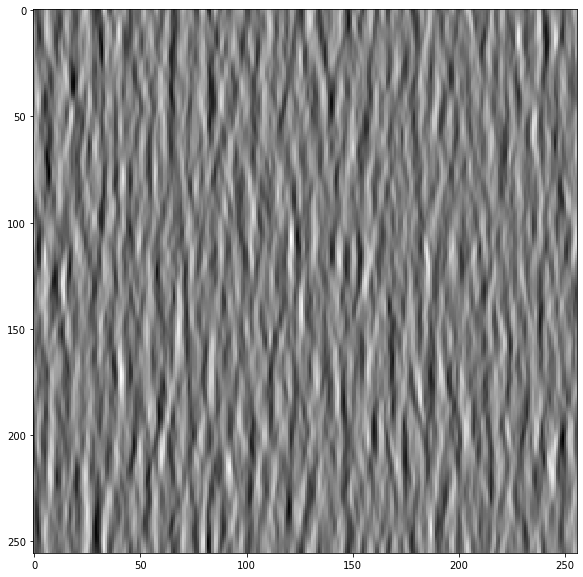

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(z.T, cmap=plt.gray())

The function generating the texture takes an envelope and multiplies it with a random phase matrix to generate the image:

In [3]:
help(mc.random_cloud)

Help on function random_cloud in module MotionClouds:

random_cloud(envelope, seed=None, impulse=False, events=None, do_amp=True)
        Returns a Motion Cloud movie as a 3D matrix from a given envelope.
    
        It first creates a random phase spectrum, multiplies with the envelope and
        then it computes the inverse FFT to obtain the spatiotemporal stimulus.
    
        Options are:
         * use a specific seed to specify the RNG's seed,
         * test the impulse response of the kernel by setting impulse to True
         * test the effect of randomizing amplitudes too by setting do_amp to True
    shape
    
        # TODO : issue a warning if more than 10% of the energy of the envelope falls off the Fourier cube
        # TODO : use a safety sphere to ensure all orientations are evenly chosen



To globally change the phase of the gabors in the texture, a "trick" is to multiply this same envelope (such that we keep it). If we keep the same seed, we keep the same phase scrambling. Then, we perform for each coefficient in the fourier space a rotation in the complex plane (that is, by multiplying by $\exp(i\cdot\phi)$). We perform this *globally* on all points of the Fourier space:

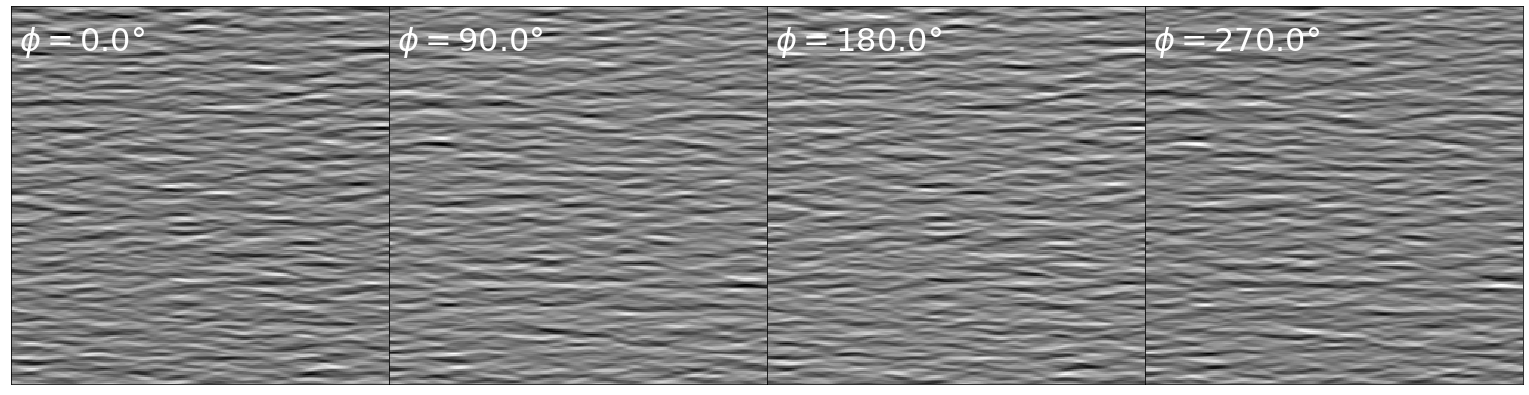

In [4]:
N_phase = 4
fig_width = 21
import numpy as np

fig, axs = plt.subplots(1, N_phase, figsize=(fig_width, fig_width/N_phase))
for i_ax, phase in enumerate(np.linspace(0, 2*np.pi, N_phase, endpoint=False)):
    im = mc.rectif(mc.random_cloud(env*np.exp(1j * phase), seed=seed))

    axs[i_ax].imshow(im[:, :, 0], cmap=plt.gray())
    axs[i_ax].text(5, 29, r'$\phi=%.1f$°' % (phase*180/np.pi), color='white', fontsize=32)
    axs[i_ax].set_xticks([])
    axs[i_ax].set_yticks([])
#plt.tight_layout()
fig.subplots_adjust(hspace = .0, wspace = .0, left=0.0, bottom=0., right=1., top=1.)

#import os
#fig.savefig(os.path.join('../figs', 'orientation_tuning.png'))

Notice that white features become black with a multiplication of $\exp(i\cdot\pi)=-1$

For fun, let us now try to generate an animation:

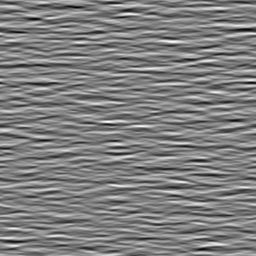

In [5]:
import imageio
from pygifsicle import optimize
N_phase = 32
fps, dpi = 8, (128, 128)

for i_phase, phase in enumerate(np.linspace(0, 2*np.pi, N_phase, endpoint=False)):
    im = (mc.rectif(mc.random_cloud(env*np.exp(1j * phase), seed=seed))*255).astype(np.uint8)
    imageio.imsave(f"/tmp/MC_phase_{i_phase:02d}.png", im, dpi=dpi)

gifname = '../files/2020-01-08-MC_phase.gif'
with imageio.get_writer(gifname, mode='I', fps=fps) as writer:
    for i_phase in range(N_phase):
        writer.append_data(imageio.imread(f"/tmp/MC_phase_{i_phase:02d}.png"))
optimize(str(gifname))
from IPython.display import Image
Image(gifname, width=2000)

For even more fun, let us now try to generate an animation of this process, but now for a natural scene:

In [6]:
N_phase = 32
fps, dpi = 8, (128, 128)

url = 'https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwww.trbimg.com%2Fimg-57c7186a%2Fturbine%2Fmc-paul-stanley-kiss-allentown-fair-20160831&f=1&nofb=1'
image = imageio.imread(url)
image.shape

(1365, 2048, 3)

In [7]:
image = image.sum(axis=-1)
image.shape

(1365, 2048)

In [8]:
image = image[:-1:2, ::2]
image.shape

(682, 1024)

In [9]:
from SLIP import Image
slip = Image('https://raw.githubusercontent.com/bicv/SLIP/master/default_param.py')
slip.set_size(image)

In [10]:
image = slip.whitening(image)

In [11]:
Fz = np.fft.fftn(image)

In [12]:
phase = 0
im = np.fft.ifftn(Fz*np.exp(1j * phase)).real

In [13]:
mc.rectif(im).min(), mc.rectif(im).max()

(0.08385036684021319, 1.0)

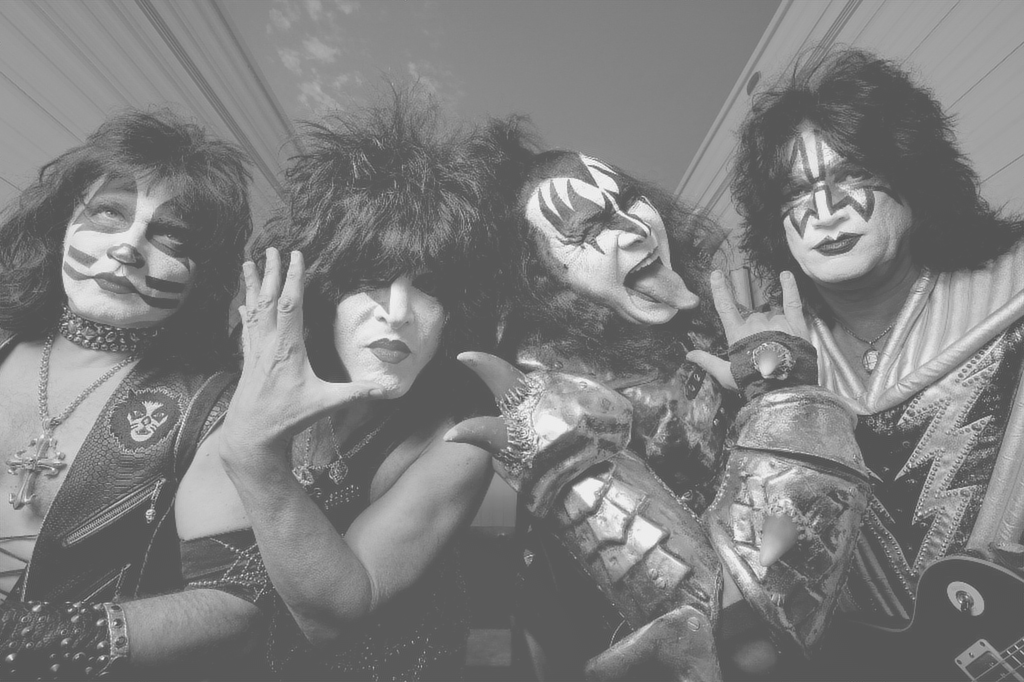

In [14]:
for i_phase, phase in enumerate(np.linspace(0, 2*np.pi, N_phase, endpoint=False)):
    # print(i_phase, phase, f"/tmp/NI_phase_{i_phase:02d}.png")
    im = np.fft.ifftn(Fz*np.exp(1j * phase)).real
    im = slip.dewhitening(im)
    im = (mc.rectif(im)*255).astype(np.uint8)
    imageio.imsave(f"/tmp/NI_phase_{i_phase:02d}.png", im, dpi=dpi)

gifname = '../files/2020-01-08-NI_phase.gif'
with imageio.get_writer(gifname, mode='I', fps=fps) as writer:
    for i_phase in range(N_phase):
        writer.append_data(imageio.imread(f"/tmp/NI_phase_{i_phase:02d}.png"))
optimize(str(gifname))
from IPython.display import Image
Image(gifname, width=2000)

Note, that doing a smooth variation of phase produces slight movements of the features, at the scale of each texton.

## some book keeping for the notebook

In [15]:
%load_ext watermark
%watermark

2020-01-24T10:44:40+01:00

CPython 3.7.6
IPython 7.11.1

compiler   : Clang 11.0.0 (clang-1100.0.33.16)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 36
interpreter: 64bit


In [16]:
%load_ext watermark
%watermark -i -h -m -v -p MotionClouds,numpy,SLIP,LogGabor,SparseEdges,matplotlib,scipy,pillow,imageio  -r -g -b

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2020-01-24T10:44:40+01:00

CPython 3.7.6
IPython 7.11.1

MotionClouds 20180606
numpy 1.18.1
SLIP 20191113
LogGabor 20191113
SparseEdges 20191118
matplotlib 3.1.2
scipy 1.4.1
pillow not installed
imageio 2.6.1

compiler   : Clang 11.0.0 (clang-1100.0.33.16)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 36
interpreter: 64bit
host name  : fortytwo
Git hash   : 4b39487945ba8245818b63440741c0aded62d451
Git repo   : https://github.com/laurentperrinet/sciblog.git
Git branch : master
